# *Iteractive reweighted least squares*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

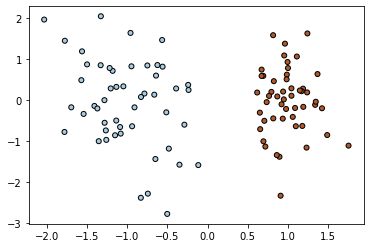

In [2]:
X, Y = make_classification(n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

In [3]:
def plot_surface(X, Y, model):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logistic_function(np.c_[xx.ravel(), yy.ravel()], model)

    # Put the result into a color plot
    class_ = np.vectorize(lambda x: 1 if x >= 0.5 else 0)
    Z = class_(Z.reshape(xx.shape))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading="auto")
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

## Solução *maximum likelihood*

$$\textbf{w}^{k+1} = (\Phi^T \textbf{R} \Phi)^{-1} \Phi^T \textbf{R} \textbf{z}$$
   
$$\textbf{z} = \Phi \textbf{w}^{k} - \textbf{R}^{-1}(\textbf{y} - \textbf{t})$$

$$\textbf{R}_{nn} = y_n(1-y_n)$$

$$ y_n = \sigma(\textbf{w}^T \Phi_n) $$

In [4]:
def logistic_function(x, w):
    return 1/(1+np.exp(-1*x.dot(w)))

def R(x,w):
    prediction = logistic_function(x,w)
    return np.diag(np.multiply(prediction, (1-prediction)).ravel())

def z(x,w,y,r):
    try:
        r_inv = np.linalg.inv(r)
    except Exception as e:
#         print(np.diag(r))
        raise e
    return x.dot(w) - r_inv.dot(logistic_function(x,w) - y)

def IRLS_ml(x,y, tol=1e-3, maxiter=100):
    w = np.zeros(x.shape[1]).reshape(-1,1)
    previous_w = None
    i = 0
    try:
        while i < maxiter and (previous_w is None or not all(np.isclose(w,previous_w, rtol=tol))):
            previous_w = np.copy(w)
            r = R(x,w)
            a = np.linalg.inv(x.T.dot(r).dot(x)).dot(x.T)
            b = r.dot(z(x,w,y.reshape(-1,1),r))
            w = a.dot(b)
            i += 1
    except Exception as e:
        # caso de R ser singular
        pass

    return w.ravel()

model_ml = IRLS_ml(X,Y)
model_ml

array([24.36583008,  2.15222023])

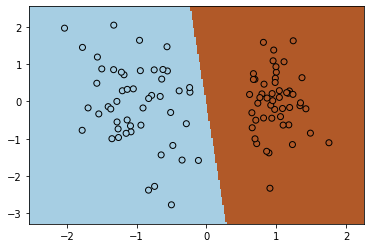

In [5]:
plot_surface(X,Y,model_ml)

## Solução *maximum a posteriori*

$$\textbf{w}^{k+1} = \textbf{w}^k + \textbf{A}^{-1}[\Phi^T (\textbf{y} - \sigma (\Phi \textbf{w}^k)) - S_0^{-1}(\textbf{w}-m_0)]$$

$$ \textbf{A} = \Phi^T \textbf{R}^k \Phi + \textbf{S}_0^{-1}$$

$$\textbf{R}_{nn}^k = y_n^k(1-y_n^k)$$

$$ y_n^k = \sigma((\textbf{w}^k)^T \Phi_n) $$

In [6]:
def A(x,w,S_inv):
    r = R(x,w)
    return x.T.dot(r).dot(x) + S_inv

def IRLS_map(x,y, m, S, tol=1e-3, maxiter=100):
    w = np.zeros(x.shape[1]).reshape(-1,1)
    previous_w = None
    i = 0
    S_inv = np.linalg.inv(S)
    m = m.reshape(-1,1)
    y = y.reshape(-1,1)
    
    while i < maxiter and (previous_w is None or not all(np.isclose(w,previous_w, rtol=tol))):
        previous_w = np.copy(w)
        a = A(x,w,S_inv)
        prediction = logistic_function(x,w)
        
        aux = x.T.dot(y-prediction) - S_inv.dot(w - m)
        
        w = w + np.linalg.inv(a).dot(aux)
        i += 1

    return w.ravel()

model_map = IRLS_map(X,Y, np.array([0,0]), np.array([[1,0],[0,1]]))
model_map

array([3.46810954, 0.23557927])

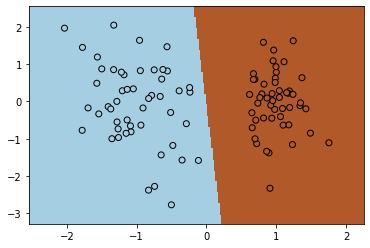

In [7]:
plot_surface(X,Y,model_map)

## Comparando os modelos

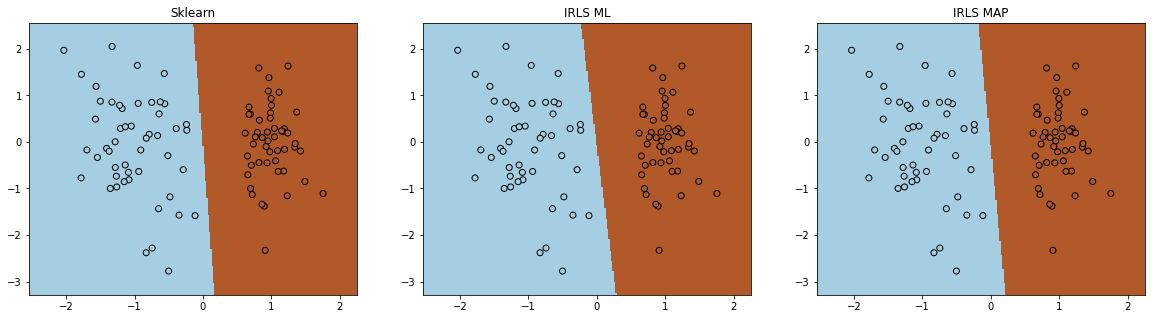

In [8]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

model_logistic = logreg.coef_.ravel()

plt.figure(figsize=(20,5))
plt.subplots_adjust(hspace=.4)

plt.subplot(1,3,1)
plot_surface(X,Y,model_logistic)
plt.title("Sklearn")

plt.subplot(1,3,2)
plot_surface(X,Y,model_ml)
plt.title("IRLS ML")

plt.subplot(1,3,3)
plot_surface(X,Y,model_map)
_ = plt.title("IRLS MAP")